<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

#Importing libraries and loading the dataset

In [55]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#for scaling
from sklearn.preprocessing import StandardScaler

#for plotting
#correlations matrix
import seaborn as sns 

#MODEL
#train-test split
from sklearn.model_selection import train_test_split

#kfold creation
from sklearn.model_selection import KFold

#RandomizedSearch for hyperParameter tunning
from sklearn.model_selection import RandomizedSearchCV

#RandomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import sklearn.tree as tree

#metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score,\
                          plot_confusion_matrix

In [2]:
#loading dataset
from google.colab import drive
drive.mount('/content/drive')
path_marcelo = ""
path_ben = ""
path_javier = "/content/drive/MyDrive/BSE/Computational Machine learning/assignments/Tree_based_models_project/"

Mounted at /content/drive


In [3]:
#loading train data
df =  pd.read_csv(path_javier + "churn_data.csv", sep = ";", decimal = ".")
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
df.head(4)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6


# Defining Functions and important vars

In [57]:
def check_categoricals_and_binaries(df, max_dif_cat_considered):
  """It gets the variables that are binary or categorical by checking first if the
  type of the variable is integer or string(we asume categorical values
  are integers and strings) and then if the number of possible values are 2 (binary) 
  or between 2 or a specified number of values (categorical). The inputs are
  the DataFrame and the int max_dif_cat_considered. The output is a list of names
  for the binary vars, and a dict for the categoricals with name : quantity of values.
  """
  categoricals = dict()
  binaries = list()
  for column in df.columns:
    dif_pos_values = len(df[column].unique())
    if dif_pos_values == 2:
      binaries.append(column)
    elif dif_pos_values > 2 and dif_pos_values < max_dif_cat_considered:
      categoricals[column] = dif_pos_values
  return binaries, categoricals


def check_outliers(df, vars_without_outliers):
  """It gets the df and a list of variables that dont have outliers (categorical
  and binary vars) and returns a dictionary with the total number of outliers
  and the index of them for each var that HAS outliers
  """
  outliers = dict()
  for column in df.columns:
    if column in vars_without_outliers:
      continue
    else:
      q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)

      IQR = q75 - q25
      lower,upper = q25 - IQR*1.5, q75 + IQR*1.5
      outliers_index = ((df[column] < lower) | (df[column] > upper))

      if len(outliers_index == True) == 0:
        continue
      else:
        output = {
            "indexes" : outliers_index,
            "quantity" : outliers_index.sum(axis = 0)
        }
        outliers[column] = output
  return outliers

def outliers_printer(df, vars_list):
  i=1
  plt.figure(figsize = (20,10))
  for col in vars_list:
   
    plt.subplot(3,3,i)
    sns.boxplot(df[col])

    i=i+1

def careful_standardization(df, not_standardize_list):
  """ This function receives the DataFrame and a list of variables not to standardize
  (for example the target, binary variables, or dummy variables(categorical vars
  should have been dummified). Also can receive sub strings of dummified categorical vars.
  For example, neigborhoodcode when dummified turns into neigborhoodcode_1, neigborhoodcode_2...
  so by putting the string 'neigborhoodcode_' inside the list no dummy of 'neigborhoodcode_' will
  be standardized). The output is the same DataFrame with all the other columns standardized. 
  """
  standardize_vars_cols = []
  dummy_vars_and_y = []

  for column in df.columns:
    for element in not_standardize_list:
    
      if element in column:
        save = False
        break
      else:
        save = True

    if save:
      standardize_vars_cols.append(column)
    else:
      dummy_vars_and_y.append(column)

  # scaler
  scaler = StandardScaler().fit(df[standardize_vars_cols])
  scaled_features = scaler.transform(df[standardize_vars_cols])
  df_scaled = pd.DataFrame(scaled_features, index = df.index, columns = df[standardize_vars_cols].columns)
  df_scaled[dummy_vars_and_y] = df[dummy_vars_and_y]

  return df_scaled

def CV_model(X , y, kf, model):
  best_f1 = 0
  final_model = None
  final_y_pred = None
  metrics = None

  accuracies = []
  recalls = []
  f1s = []

  for train_index, test_index in kf.split(X):

    X_train, X_test = np.matrix(X)[train_index], np.matrix(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_sc = f1_score(y_test, y_pred)

    f1s.append(f1_sc)
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

    if f1_sc > best_f1:
      
      final_model = model
      final_y_pred = y_pred
      best_f1 = f1_sc

    

    return final_model, final_y_pred, metrics

In [6]:
#defining global vars that will be used through the project
TARGET = "Churn"
SEED = 1  #this var is for random states so we dont change it by mistake from one step to anodet (for consistency)
          #and putting this name will help with readibility too

# Working the Data

In [7]:
#detecting binary and categorical vars
binaries, categoricals = check_categoricals_and_binaries(df_copy, 50)
print(binaries)
print(categoricals)

['Churn', 'ContractRenewal', 'DataPlan']
{'CustServCalls': 10}


In [8]:
#detecting vars with outliers
vars_without_outliers = binaries + list(categoricals.keys())
outliers = check_outliers(df_copy, vars_without_outliers)

print(outliers.keys())

dict_keys(['AccountWeeks', 'DataUsage', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

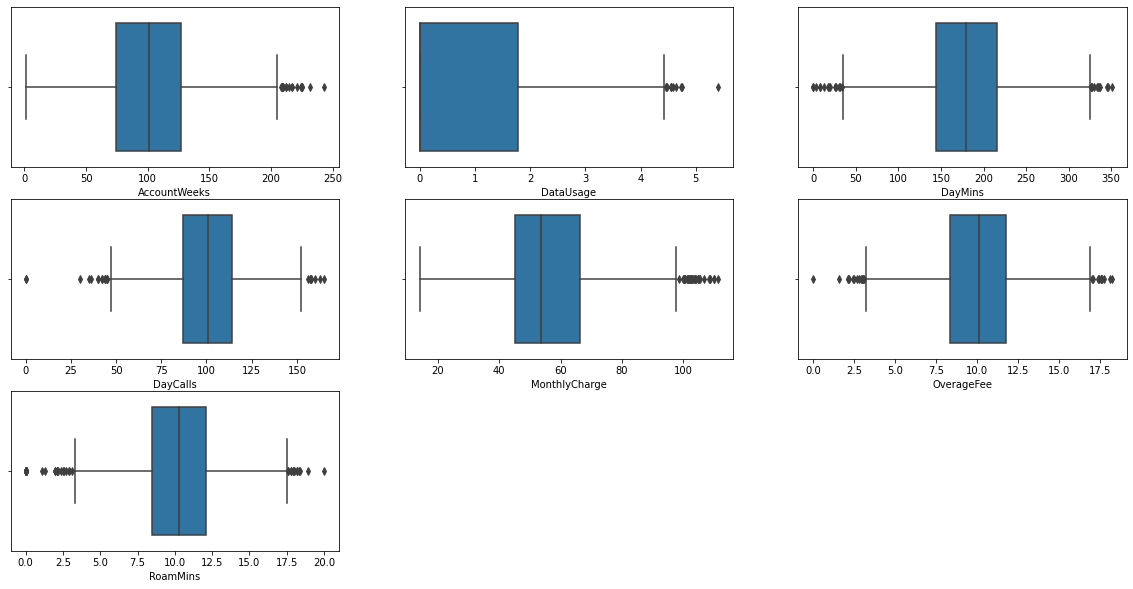

In [9]:
#visualizing outliers
outliers_printer(df_copy, outliers.keys())

In [ ]:
#fixing outliers? maybe but not sure

In [ ]:
#analyzing vars distribution to see if logs are needed

In [14]:
#creating new vars (logs of non categorical nor binary vars for example) if needed
df_copy['DayMins_per_call'] = round(df['DayMins']/(df['DayCalls']),2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


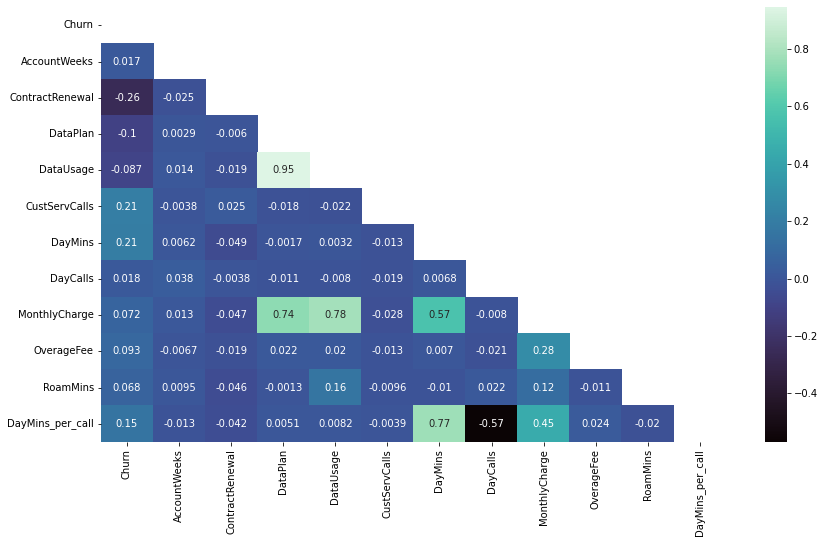

In [15]:
#visualazing correlation matrix
import seaborn as sns 
# Let's calculate the correlations
df_corr = df_copy.corr()

# Plot correlations
# Remove upper triangle
palette = sns.color_palette("mako", as_cmap=True)
fig, ax = plt.subplots(figsize=(14,8))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask = mask, annot = True, cmap = palette)

In [12]:
#separating into x and y and standardizing x. Not creating train and test sets yet
not_standardize_list = binaries
if TARGET not in binaries:
  not_standardize_list.append(TARGET)

df_scaled = careful_standardization(df_copy, not_standardize_list)
X = df_scaled.drop(columns=[TARGET])
y = df_scaled[TARGET]

df_scaled.head(4)

,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn,ContractRenewal,DataPlan
0,0.676489,1.480204,-0.427932,1.566767,0.476643,1.990727,-0.071584,-0.085008,0,1,1
1,0.149065,2.266072,-0.427932,-0.333738,1.124503,1.564510,-0.107082,1.240482,0,1,1
2,0.902529,-0.641642,-1.188218,1.168304,0.675985,-0.262133,-1.574346,0.703121,0,1,0
3,-0.428590,-0.641642,0.332354,2.196596,-1.466936,0.042307,-2.741846,-1.303026,0,0,0


# Model analysis

is this a regression or classification? not sure...

In [36]:
#separating data into train and test
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)

In [56]:
#creating Randomized search for hyperParameter tunning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Algorithm implemented with cross-validation. #At least Random Forest and Xgboost are used.
#Cross-validation used
#AUC score given
#Hyperparameter optimization
#maybe we can define a set of functions that work together to loop through all the hyper parameters
#trying to find the optimum point. Maybe we can try regression and classification? Dont know
#which one will be the best one as we only have to give a 1/0 as a prediction. maybe regression together with
#optimizing for the best threshold using the f1 socre gives good results.
forest_class = RandomForestClassifier()

clf = RandomizedSearchCV(forest_class, random_grid, n_iter=10, scoring = "f1", n_jobs = 8, random_state=SEED, cv = 2)

best_score = 0
final_model = None
final_y_test = None
f1s = []
for train_index, test_index in kf.split(X):

    X_train, X_test = np.matrix(X)[train_index], np.matrix(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f1_sc = f1_score(y_test, y_pred)
    f1s.append(f1_sc)

    if f1_sc > best_score:
      best_score = f1_sc
      final_model = clf


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

In [30]:
#RandomForestClassifier
forest_class = RandomForestClassifier()
forest_class.fit(X_train, y_train)

print(accuracy_score(y_test, forest_class.predict(X_test)))
print(f1_score(y_test, forest_class.predict(X_test)))

0.9370314842578711
0.7558139534883722


In [ ]:
#results visualization. ROC curve of both, features importances, confusion matrix